## YouTube Trending Project
* ### Machine Learning Models

### Table of Contents:
* 1.Exploratory Data Analysis
* 2.Data Cleaning
* 3.Modeling
    * 3.1 Predicting Likes
        * 3.1.1 Pre-processing Data
            * 3.1.1.1 Train-Test Split (80:20)
            * 3.1.1.2 Initializing Pre-processing Pipeline
        * 3.1.2 Hyperparameter Tuning (Gridsearch)
        * 3.1.3 Regressors
            * 3.1.3.1 Linear Regression
            * 3.1.3.2 Random Forest
            * 3.1.3.3 XGBoost
        * 3.1.4 Random Forest
            * 3.1.4.1 Feature Importance
        * 3.1.5 Likes Evaluation
    * 3.2 Predicting Views
        * 3.2.1 Pre-processing Data
            * 3.2.1.1 Train-Test Split (80:20)
            * 3.2.1.2 Initializing Pre-processing Pipeline
        * 3.2.2 Hyperparameter Tuning (Gridsearch)
        * 3.2.3 Regressors
            * 3.2.3.1 Linear Regression
            * 3.2.3.2 Random Forest
            * 3.2.3.3 XGBoost
        * 3.2.4 Random Forest
            * 3.2.4.1 Feature Importance
        * 3.2.5 Views Evaluation
    * 3.3 Predicting Comment Count
        * 3.3.1 Pre-processing Data
            * 3.3.1.1 Train-Test Split (80:20)
            * 3.3.1.2 Initializing Pre-processing Pipeline
        * 3.3.2 Hyperparameter Tuning (Gridsearch)
        * 3.3.3 Regressors
            * 3.3.3.1 Linear Regression
            * 3.3.3.2 Decision Trees
            * 3.3.3.3 Random Forest
        * 3.3.4 Random Forest
            * 3.1.4.1 Feature Importance

### 3. Machine Learning Models
##### Loading Data and Libraries

In [1]:
import helpers
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Encoding and Data Split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Modeling
from sklearn import metrics
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Tuning
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Reading the stitched data
df = helpers.load_df("Data/Curated_US_Data.csv")

df.head()

,categoryId,likeRatio,likes_log,views_log,dislikes_log,comment_log,days_lapse,durationHr,durationMin,durationSec,titleLength,tagCount
0,25,0.876818,11.457423,15.708863,8.733755,10.990247,0.0,1,59,15,66,12
1,10,0.985548,14.211013,15.832615,9.288227,11.853311,0.0,0,2,58,42,22
2,10,0.974122,11.938376,14.220534,7.603898,9.306832,1.0,0,3,0,42,26
3,22,0.976673,13.299495,15.487011,8.859931,10.423709,2.0,0,5,55,35,0
4,10,0.984114,11.315194,13.667111,6.487684,8.402680,1.0,0,2,59,47,22


### 3.1 Predicting Likes
#### 3.1.1 Preprocessing Data
##### 3.1.1.1 Train-Test Split (80:20)
Splitting the data into train and test sets in a 80:20 ratio

In [2]:
X = df.drop(columns=['likes_log'])
y = df['likes_log']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

##### 3.1.1.2 Initializing Preprocessing Pipeline
Scaling numercal data and encoding categorical data

In [4]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).drop(['durationHr','durationMin','durationSec', 'categoryId'],axis=1).columns
categorical_features = list(X.select_dtypes(include=['object']).columns) + ['durationHr','durationMin','durationSec', 'categoryId']

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numeric_features),
        ('categorical', OneHotEncoder(handle_unknown = "ignore"), categorical_features)])

y

0       11.457423
1       14.211013
2       11.938376
3       13.299495
4       11.315194
          ...    
2731    12.388952
2732    10.343966
2733    13.291704
2734    10.807706
2735     8.847791
Name: likes_log, Length: 2736, dtype: float64

In [5]:
print('Numeric Features:', numeric_features)
print('Categorical Features:', categorical_features)

Numeric Features: Index(['likeRatio', 'views_log', 'dislikes_log', 'comment_log', 'days_lapse',
       'titleLength', 'tagCount'],
      dtype='object')
Categorical Features: ['durationHr', 'durationMin', 'durationSec', 'categoryId']


#### 3.1.2 Hyperparameter Tuning (Optuna)
Using bayesian hyperparameter optimization to find optimal parameters

In [6]:
# Define Objective Function to be Maximized
def rfObjective(trial):
    # Define Random Forest Parameters
    rfParams={
        'n_estimators' : trial.suggest_int('n_estimators', 100, 500),
        'max_depth' : trial.suggest_int('max_depth', 1, 50),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1,15),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2,15)
    }
    
    # Establish Random Forest Regressor Pipeline
    rfPipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(
        **rfParams
    ))])
    
    for step in range(100):
        rfPipe.fit(X_train,y_train)
        
        # Report Intermediate Objective Value
        intermediate_value = rfPipe.score(X_test, y_test)
        trial.report(intermediate_value, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        return intermediate_value

# Running the Study
rfStudy = optuna.create_study(direction='maximize')
rfStudy.optimize(rfObjective, n_trials=100)

# Calculating the pruned and completed trials
pruned_trials = [t for t in rfStudy.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in rfStudy.trials if t.state == optuna.trial.TrialState.COMPLETE]

rfTrial = rfStudy.best_trial

print('Number of finished trials: ', len(rfStudy.trials))
print('Number of pruned trials: ', len(pruned_trials))
print('Number of complete trials: ', len(complete_trials))

print('Accuracy: {}'.format(rfTrial.value))
print("Best hyperparameters: {}".format(rfTrial.params))

[I 2021-01-27 15:28:40,018] A new study created in memory with name: no-name-f8ebc6e0-c762-432d-b103-2752a247fd7b
[I 2021-01-27 15:28:51,463] Trial 0 finished with value: 0.9836961159955493 and parameters: {'n_estimators': 472, 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 8}. Best is trial 0 with value: 0.9836961159955493.
[I 2021-01-27 15:28:54,982] Trial 1 finished with value: 0.9847920923155397 and parameters: {'n_estimators': 132, 'max_depth': 43, 'min_samples_leaf': 2, 'min_samples_split': 12}. Best is trial 1 with value: 0.9847920923155397.
[I 2021-01-27 15:29:02,211] Trial 2 finished with value: 0.9881687498532724 and parameters: {'n_estimators': 199, 'max_depth': 37, 'min_samples_leaf': 2, 'min_samples_split': 4}. Best is trial 2 with value: 0.9881687498532724.
[I 2021-01-27 15:29:09,849] Trial 3 finished with value: 0.9683382567427149 and parameters: {'n_estimators': 436, 'max_depth': 33, 'min_samples_leaf': 11, 'min_samples_split': 13}. Best is trial 2 with val

In [7]:
# Define Objective Function to be Maximized
def xgbObjective(trial):
    # Define XGBoost Parameters
    xgbParams = {
        'n_estimators' : trial.suggest_int('n_estimators', 100,500),
        'max_depth' : trial.suggest_int('max_depth', 1, 20),
        'eta' : trial.suggest_uniform('eta', 0.01, 1), # learning_rate
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_int('gamma', 0, 10), # min_split_loss
        'min_child_weight' : trial.suggest_uniform('min_child_weight', 0.1, 1.0)
    }

    # Establish XGBoost Regressor Pipeline
    xgbPipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', xgb.XGBRegressor(
        **xgbParams
    ))])
    
    for step in range(100):
        xgbPipe.fit(X_train,y_train)
        
        # Report Intermediate Objective Value
        intermediate_value = xgbPipe.score(X_test, y_test)
        trial.report(intermediate_value, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        return intermediate_value

# Running the Study
xgbStudy = optuna.create_study(direction='maximize')
xgbStudy.optimize(xgbObjective, n_trials=100)

# Calculating the pruned and completed trials
pruned_trials = [t for t in xgbStudy.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in xgbStudy.trials if t.state == optuna.trial.TrialState.COMPLETE]

xgbTrial = xgbStudy.best_trial

print('Number of finished trials: ', len(xgbStudy.trials))
print('Number of pruned trials: ', len(pruned_trials))
print('Number of complete trials: ', len(complete_trials))

print('Accuracy: {}'.format(xgbTrial.value))
print("Best hyperparameters: {}".format(xgbTrial.params))
    

[I 2021-01-27 15:50:21,132] A new study created in memory with name: no-name-3832c29a-25e0-42c0-9f9e-22019dac62c5
[I 2021-01-27 15:50:23,302] Trial 0 finished with value: 0.9276268924614586 and parameters: {'n_estimators': 410, 'max_depth': 10, 'eta': 0.5227249366042929, 'subsample': 0.20256533986155387, 'colsample_bytree': 0.5380356192980869, 'gamma': 10, 'min_child_weight': 0.9913614228781356}. Best is trial 0 with value: 0.9276268924614586.
[I 2021-01-27 15:50:26,809] Trial 1 finished with value: 0.9416365139542069 and parameters: {'n_estimators': 466, 'max_depth': 11, 'eta': 0.416759295882645, 'subsample': 0.47314467210999334, 'colsample_bytree': 0.5252960253728668, 'gamma': 5, 'min_child_weight': 0.559456285053388}. Best is trial 1 with value: 0.9416365139542069.
[I 2021-01-27 15:50:28,337] Trial 2 finished with value: 0.9431634607705041 and parameters: {'n_estimators': 287, 'max_depth': 9, 'eta': 0.0905507047697994, 'subsample': 0.2141774075748256, 'colsample_bytree': 0.829858809

#### 3.1.3 Regressors
* ##### 3.1.3.1 Linear Regression
* ##### 3.1.3.2 Random Forest
* ##### 3.1.3.3 XGBoost


LinearRegression()
Model Score: 0.930
mae:  0.30764861304915814
mse:  0.1617673139041401
rmse:  0.40220307545335865 

RandomForestRegressor(max_depth=27, n_estimators=351)
Model Score: 0.989
mae:  0.09483985209006109
mse:  0.025642692968558062
rmse:  0.16013335994900646 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7881249824269301,
             eta=0.12593016196808654, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.12593016, max_delta_step=0, max_depth=4,
             min_child_weight=0.3453518542314287, missing=nan,
             monotone_constraints='()', n_estimators=311, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.5356601743816992,
             tree_method='exact', validate_parameters=1, verbosity=None)
Model Score: 0.995
mae:  0.07643605147316625
mse:  0

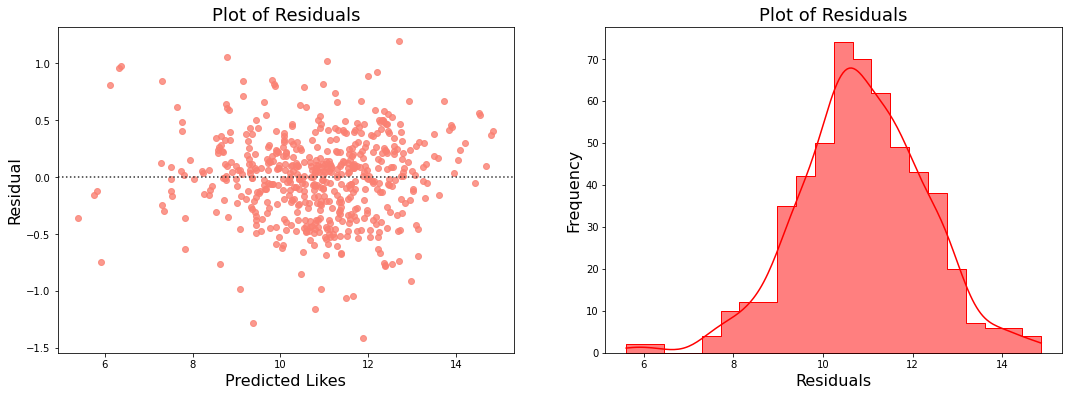

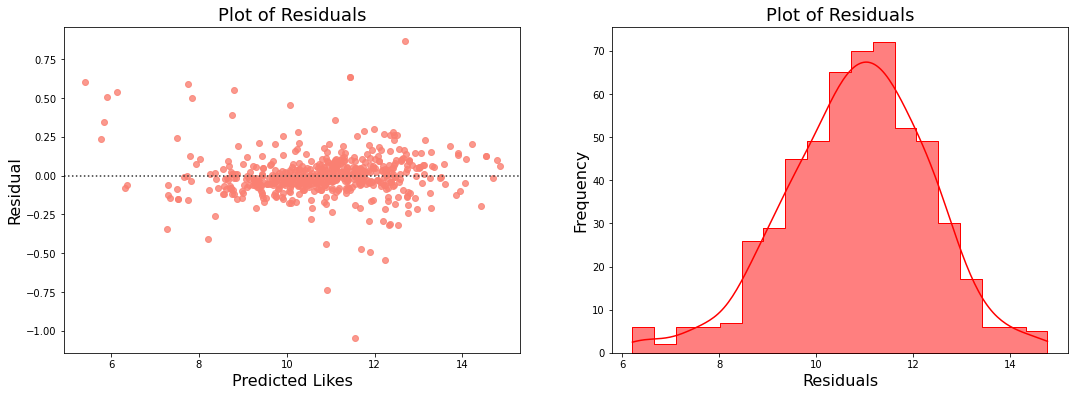

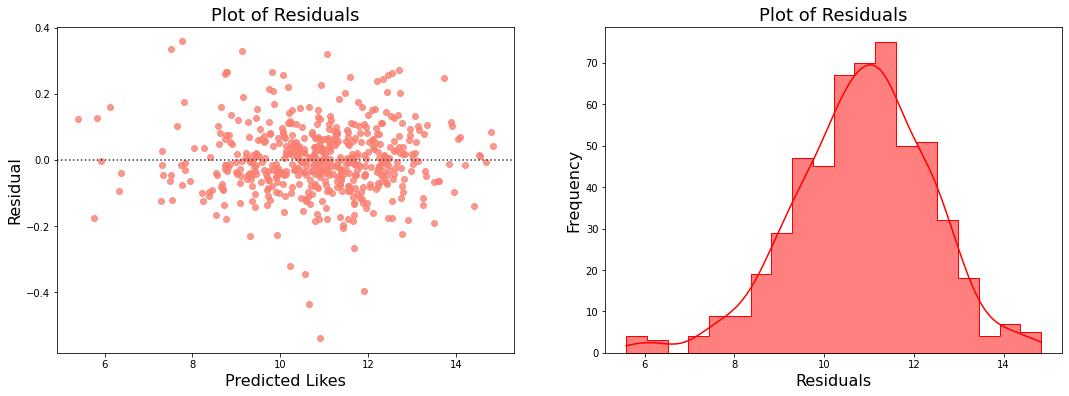

In [8]:
regressors = [
        LinearRegression(),
        RandomForestRegressor(**rfTrial.params),
        xgb.XGBRegressor(**xgbTrial.params),
    ]

for regressor in regressors:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', regressor)])
    pipe.fit(X_train, y_train)   
    print(regressor)
    
    y_pred = pipe.predict(X_test)
    d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}

    print("Model Score: %.3f" % pipe.score(X_test, y_test))
    mae = metrics.mean_absolute_error(y_test, pipe.predict(X_test))
    mse = metrics.mean_squared_error(y_test,pipe.predict(X_test))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, pipe.predict(X_test)))
    print("mae: ", mae)
    print("mse: ", mse)
    print("rmse: ", rmse, "\n")

    data = pd.DataFrame(data = d1)
    # Residual Plot 1
    fig1, ax1 = plt.subplots(1,2, figsize=(18,6))
    g1 = sns.residplot(x= y_test, y= y_pred, ax=ax1[0], data = data, color="salmon")
    g1.set_xlabel('Predicted Likes', fontsize=16)
    g1.set_ylabel('Residual', fontsize=16)
    g1.set_title("Plot of Residuals", fontsize=18)

    # Residual Plot 2
    g2 = sns.histplot(x=y_pred, ax=ax1[1], data = data, element="step", color="red", kde=True)
    g2.set_xlabel('Residuals', fontsize=16)
    g2.set_ylabel('Frequency', fontsize=16)
    g2.set_title("Plot of Residuals", fontsize=18)
    
    # Linear Plot
    # lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = data, size = 10)
    # fig1 = lm1.fig 
    # fig1.suptitle("Sklearn ", fontsize=18)
    # sns.set(font_scale = 1.5)


#### 3.1.4 Random Forest Regressor

In [9]:
reg = RandomForestRegressor(**{'n_estimators': 456, 'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 3}, oob_score=True)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
              ('regressor', reg)])
pipe.fit(X_train, y_train)   
print(reg)

print("Model Train Score: %.3f" % pipe.score(X_train, y_train))
print("Model OOB Score: %.3f" % reg.oob_score_)
print("Model Test Score: %.3f" % pipe.score(X_test, y_test))

RandomForestRegressor(max_depth=16, min_samples_split=3, n_estimators=456,
                      oob_score=True)
Model Train Score: 0.998
Model OOB Score: 0.987
Model Test Score: 0.989


##### 3.1.4.1 Feature Importance

In [10]:
pd.DataFrame(zip(X.columns,reg.feature_importances_),columns=['feature','importance']).sort_values(by='importance',ascending=False)


,feature,importance
3,dislikes_log,5.914939e-01
1,likeRatio,1.532609e-01
0,categoryId,1.402504e-01
2,views_log,9.176887e-02
5,days_lapse,3.658758e-03
6,durationHr,2.254358e-03
4,comment_log,1.130112e-03
8,durationSec,4.282601e-04
7,durationMin,2.596302e-04
9,titleLength,1.531679e-05


#### 3.1.5 Likes Evaluation

In [11]:
eval = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', xgb.XGBRegressor(**xgbTrial.params))])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test) 

mae = metrics.mean_absolute_error(y_test,y_pred)
mse = metrics.mean_squared_error(y_test,y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
r2 = metrics.r2_score(y_test, y_pred)

print("mae: ", mae)
print("mse: ", mse)
print("rmse: ", rmse)
print("r2: ", r2)

mae:  0.09497980237977802
mse:  0.026526255565702834
rmse:  0.16286882932502103
r2:  0.9885605727694833


mae:  0.09433066320483678
mse:  0.0256561569785538
rmse:  0.16017539442296935
r2:  0.9889358021133465


In [12]:
df = pd.DataFrame(data=list(zip(list(y_test), list(y_pred))),columns=['actual','predicted'])

#Unlog Values
for col in df.columns:
    df[col] = df[col].apply(lambda x: np.e**x)

df

,actual,predicted
0,16246.0,1.841830e+04
1,477871.0,4.204567e+05
2,162807.0,1.777984e+05
3,1267051.0,1.096466e+06
4,199667.0,2.511548e+05
...,...,...
543,20055.0,2.889747e+04
544,51067.0,6.246055e+04
545,6624.0,6.330959e+03
546,23598.0,2.440125e+04


,actual,predicted
0,16246.0,1.861961e+04
1,477871.0,4.265289e+05
2,162807.0,1.768787e+05
3,1267051.0,1.086406e+06
4,199667.0,2.508528e+05
...,...,...
543,20055.0,2.877286e+04
544,51067.0,6.169154e+04
545,6624.0,6.439771e+03
546,23598.0,2.437966e+04


### 3.2 Predicting Views
#### 3.2.1 Preprocessing Data
##### 3.2.1.1 Train-Test Split (80:20)
Splitting the data into train and test sets in a 80:20 ratio

In [13]:
df = helpers.load_df("Data/Curated_US_Data.csv")

X = df.drop(columns=['views_log'])
y = df['views_log']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

##### 3.2.1.2 Initializing Preprocessing Pipeline
Scaling numercal data and encoding categorical data

In [15]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).drop(['durationHr','durationMin','durationSec', 'categoryId'],axis=1).columns
categorical_features = list(X.select_dtypes(include=['object']).columns) + ['durationHr','durationMin','durationSec', 'categoryId']

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numeric_features),
        ('categorical', OneHotEncoder(handle_unknown = "ignore"), categorical_features)])

y

0       15.708863
1       15.832615
2       14.220534
3       15.487011
4       13.667111
          ...    
2731    14.933087
2732    12.728645
2733    16.079583
2734    13.822260
2735    12.871561
Name: views_log, Length: 2736, dtype: float64

0       15.708863
1       15.832615
2       14.220534
3       15.487011
4       13.667111
          ...    
2731    14.933087
2732    12.728645
2733    16.079583
2734    13.822260
2735    12.871561
Name: views_log, Length: 2736, dtype: float64

In [16]:
print('Numeric Features:', numeric_features)
print('Categorical Features:', categorical_features)

Numeric Features: Index(['likeRatio', 'likes_log', 'dislikes_log', 'comment_log', 'days_lapse',
       'titleLength', 'tagCount'],
      dtype='object')
Categorical Features: ['durationHr', 'durationMin', 'durationSec', 'categoryId']


Numeric Features: Index(['likeRatio', 'likes_log', 'dislikes_log', 'comment_log', 'days_lapse',
       'titleLength', 'tagCount'],
      dtype='object')
Categorical Features: ['durationHr', 'durationMin', 'durationSec', 'categoryId']


#### 3.2.2 Hyperparameter Tuning (Optuna)
Using bayesian hyperparameter optimization to find optimal parameters

In [17]:
# Define Objective Function to be Maximized
def rfObjective(trial):
    # Define Random Forest Parameters
    rfParams={
        'n_estimators' : trial.suggest_int('n_estimators', 100, 500),
        'max_depth' : trial.suggest_int('max_depth', 1, 50),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1,15),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2,15)
    }
    
    # Establish Random Forest Regressor Pipeline
    rfPipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(
        **rfParams
    ))])
    
    for step in range(100):
        rfPipe.fit(X_train,y_train)
        
        # Report Intermediate Objective Value
        intermediate_value = rfPipe.score(X_test, y_test)
        trial.report(intermediate_value, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        return intermediate_value

# Running the Study
rfStudy = optuna.create_study(direction='maximize')
rfStudy.optimize(rfObjective, n_trials=100)

# Calculating the pruned and completed trials
pruned_trials = [t for t in rfStudy.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in rfStudy.trials if t.state == optuna.trial.TrialState.COMPLETE]

rfTrial = rfStudy.best_trial

print('Number of finished trials: ', len(rfStudy.trials))
print('Number of pruned trials: ', len(pruned_trials))
print('Number of complete trials: ', len(complete_trials))

print('Accuracy: {}'.format(rfTrial.value))
print("Best hyperparameters: {}".format(rfTrial.params))

[I 2021-01-27 14:36:44,494] A new study created in memory with name: no-name-96164fcf-229c-4150-a530-2f4b57b39e24
[I 2021-01-27 14:36:58,568] Trial 0 finished with value: 0.9239519052275517 and parameters: {'n_estimators': 406, 'max_depth': 29, 'min_samples_leaf': 1, 'min_samples_split': 10}. Best is trial 0 with value: 0.9239519052275517.
[I 2021-01-27 14:37:03,639] Trial 1 finished with value: 0.9059668096897031 and parameters: {'n_estimators': 193, 'max_depth': 29, 'min_samples_leaf': 5, 'min_samples_split': 2}. Best is trial 0 with value: 0.9239519052275517.
[I 2021-01-27 14:37:06,160] Trial 2 finished with value: 0.8887220639618498 and parameters: {'n_estimators': 127, 'max_depth': 19, 'min_samples_leaf': 9, 'min_samples_split': 10}. Best is trial 0 with value: 0.9239519052275517.
[I 2021-01-27 14:37:23,810] Trial 3 finished with value: 0.9317060068500336 and parameters: {'n_estimators': 406, 'max_depth': 48, 'min_samples_leaf': 1, 'min_samples_split': 4}. Best is trial 3 with val

[I 2021-01-27 15:53:43,962] A new study created in memory with name: no-name-7747c2d5-b7e4-4118-a40c-703d2f4b614b
[I 2021-01-27 15:53:45,643] Trial 0 finished with value: 0.8774106030417739 and parameters: {'n_estimators': 105, 'max_depth': 37, 'min_samples_leaf': 13, 'min_samples_split': 14}. Best is trial 0 with value: 0.8774106030417739.
[I 2021-01-27 15:53:52,329] Trial 1 finished with value: 0.9131488539848984 and parameters: {'n_estimators': 262, 'max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 8}. Best is trial 1 with value: 0.9131488539848984.
[I 2021-01-27 15:53:59,537] Trial 2 finished with value: 0.8795198877935336 and parameters: {'n_estimators': 456, 'max_depth': 19, 'min_samples_leaf': 13, 'min_samples_split': 3}. Best is trial 1 with value: 0.9131488539848984.
[I 2021-01-27 15:54:07,250] Trial 3 finished with value: 0.8831296505958306 and parameters: {'n_estimators': 438, 'max_depth': 45, 'min_samples_leaf': 11, 'min_samples_split': 6}. Best is trial 1 with v

In [18]:
# Define Objective Function to be Maximized
def xgbObjective(trial):
    # Define XGBoost Parameters
    xgbParams = {
        'n_estimators' : trial.suggest_int('n_estimators', 100,500),
        'max_depth' : trial.suggest_int('max_depth', 1, 20),
        'eta' : trial.suggest_uniform('eta', 0.01, 1), # learning_rate
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_int('gamma', 0, 10), # min_split_loss
        'min_child_weight' : trial.suggest_uniform('min_child_weight', 0.1, 1.0)
    }

    # Establish XGBoost Regressor Pipeline
    xgbPipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', xgb.XGBRegressor(
        **xgbParams
    ))])
    
    for step in range(100):
        xgbPipe.fit(X_train,y_train)
        
        # Report Intermediate Objective Value
        intermediate_value = xgbPipe.score(X_test, y_test)
        trial.report(intermediate_value, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        return intermediate_value

# Running the Study
xgbStudy = optuna.create_study(direction='maximize')
xgbStudy.optimize(xgbObjective, n_trials=100)

# Calculating the pruned and completed trials
pruned_trials = [t for t in xgbStudy.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in xgbStudy.trials if t.state == optuna.trial.TrialState.COMPLETE]

xgbTrial = xgbStudy.best_trial

print('Number of finished trials: ', len(xgbStudy.trials))
print('Number of pruned trials: ', len(pruned_trials))
print('Number of complete trials: ', len(complete_trials))

print('Accuracy: {}'.format(xgbTrial.value))
print("Best hyperparameters: {}".format(xgbTrial.params))
    

[I 2021-01-27 15:01:44,866] A new study created in memory with name: no-name-6f35dd44-2ff6-43e8-9fa0-8427fd6f3d44
[I 2021-01-27 15:01:46,948] Trial 0 finished with value: 0.8597308468961558 and parameters: {'n_estimators': 363, 'max_depth': 11, 'eta': 0.5475558092097419, 'subsample': 0.45354300418792315, 'colsample_bytree': 0.38362112434708195, 'gamma': 4, 'min_child_weight': 0.1737507680026853}. Best is trial 0 with value: 0.8597308468961558.
[I 2021-01-27 15:01:54,068] Trial 1 finished with value: 0.847956199003044 and parameters: {'n_estimators': 371, 'max_depth': 14, 'eta': 0.4246991968082106, 'subsample': 0.9439093014196304, 'colsample_bytree': 0.7722768957894632, 'gamma': 8, 'min_child_weight': 0.2693790334660988}. Best is trial 0 with value: 0.8597308468961558.
[I 2021-01-27 15:01:54,436] Trial 2 finished with value: 0.8242089881830911 and parameters: {'n_estimators': 345, 'max_depth': 1, 'eta': 0.8189216631329795, 'subsample': 0.9078288149444902, 'colsample_bytree': 0.758334990

[I 2021-01-27 16:12:46,292] A new study created in memory with name: no-name-f4234319-a1d2-4ad8-8790-c8a2352f8eec
[I 2021-01-27 16:12:47,054] Trial 0 finished with value: 0.8589255522642097 and parameters: {'n_estimators': 167, 'max_depth': 7, 'eta': 0.13598710849403572, 'subsample': 0.8082275953526858, 'colsample_bytree': 0.4146214171228826, 'gamma': 7, 'min_child_weight': 0.14632806584971134}. Best is trial 0 with value: 0.8589255522642097.
[I 2021-01-27 16:12:48,157] Trial 1 finished with value: 0.8261152665127104 and parameters: {'n_estimators': 148, 'max_depth': 16, 'eta': 0.47739637961205267, 'subsample': 0.4175324290452399, 'colsample_bytree': 0.18193704724846926, 'gamma': 4, 'min_child_weight': 0.7738748306468148}. Best is trial 0 with value: 0.8589255522642097.
[I 2021-01-27 16:12:48,610] Trial 2 finished with value: 0.8125765415569741 and parameters: {'n_estimators': 371, 'max_depth': 2, 'eta': 0.4908971903175011, 'subsample': 0.6399027877243875, 'colsample_bytree': 0.1195280

#### 3.2.3 Regressors
* ##### 3.2.3.1 Linear Regression
* ##### 3.2.3.2 Random Forest
* ##### 3.2.3.3 XGBoost


LinearRegression()
Model Score: 0.879
mae:  0.2944756775768164
mse:  0.15599691668124369
rmse:  0.3949644498954858 

RandomForestRegressor(max_depth=34, n_estimators=421)
Model Score: 0.932
mae:  0.2034491364753415
mse:  0.08739098024704253
rmse:  0.2956196547035439 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5523708533702404,
             eta=0.20963116778274138, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.209631175, max_delta_step=0, max_depth=11,
             min_child_weight=0.9491111348393968, missing=nan,
             monotone_constraints='()', n_estimators=380, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.9255693126404338,
             tree_method='exact', validate_parameters=1, verbosity=None)
Model Score: 0.946
mae:  0.17331119206798962
mse:  0.0

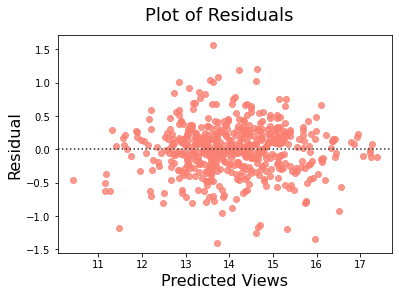

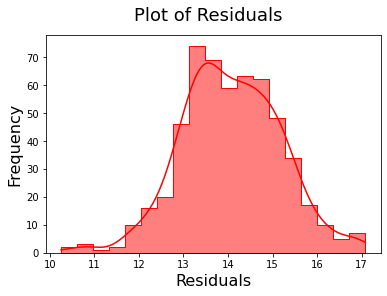

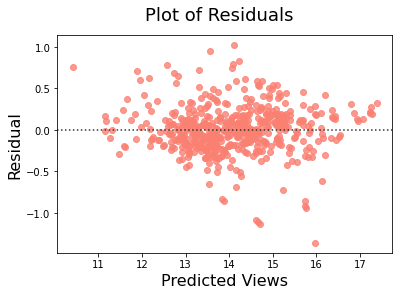

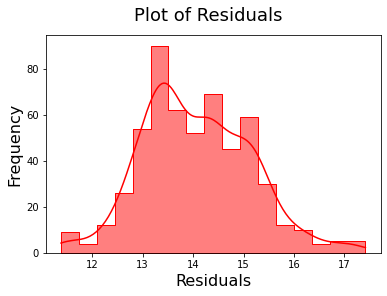

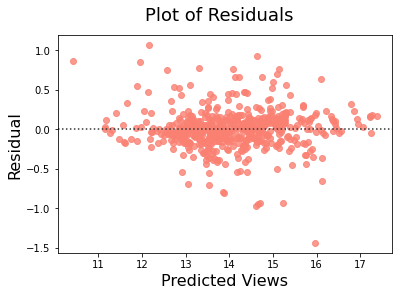

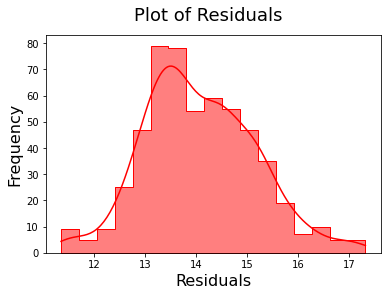

LinearRegression()
Model Score: 0.879
mae:  0.2944756775768164
mse:  0.15599691668124369
rmse:  0.3949644498954858 

RandomForestRegressor(max_depth=46, n_estimators=472)
Model Score: 0.932
mae:  0.20322791996720316
mse:  0.0874052119526131
rmse:  0.29564372469682676 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3852434323353095,
             eta=0.13212081295522196, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.132120818, max_delta_step=0, max_depth=8,
             min_child_weight=0.6943603037448846, missing=nan,
             monotone_constraints='()', n_estimators=482, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8159785209404634,
             tree_method='exact', validate_parameters=1, verbosity=None)
Model Score: 0.944
mae:  0.1702724011339899
mse:  0.07

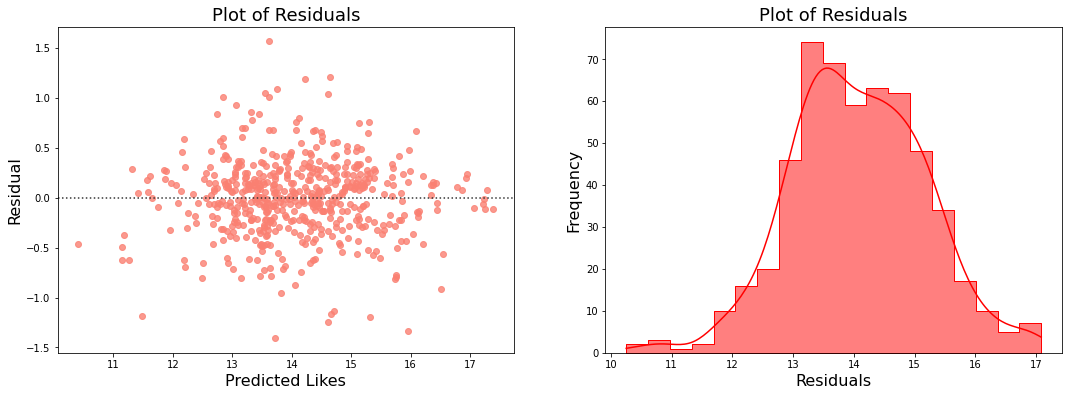

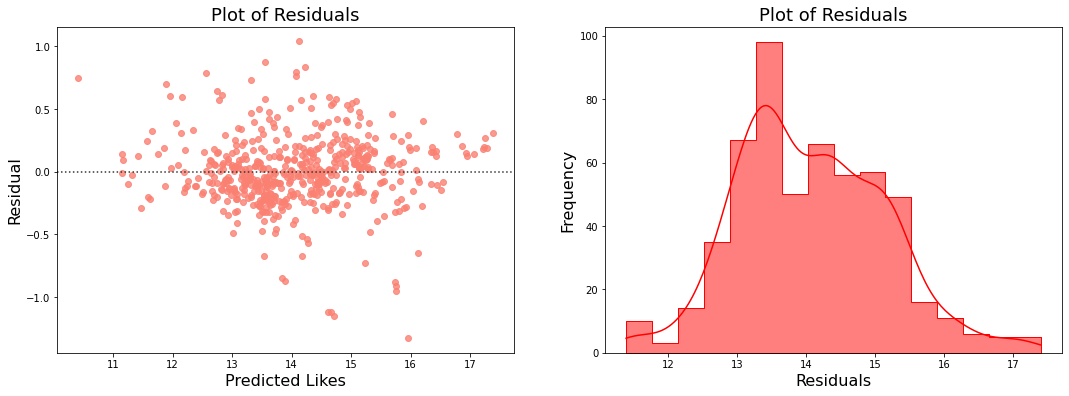

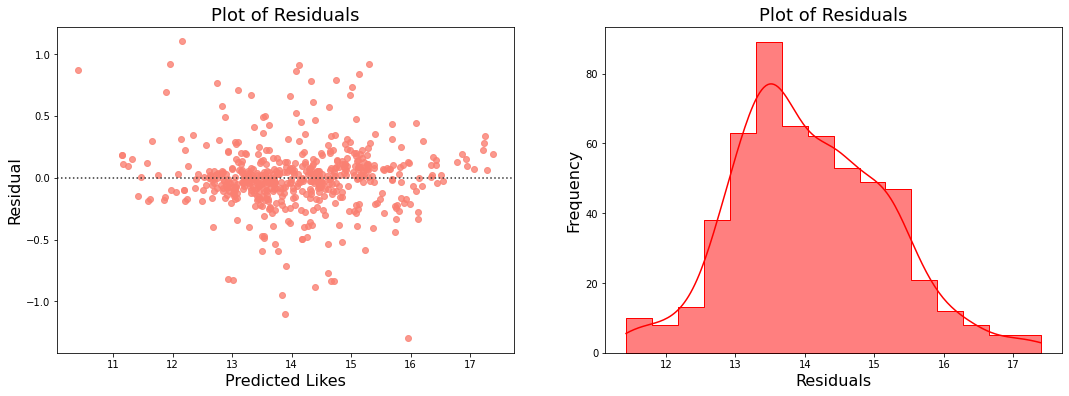

In [19]:
regressors = [
        LinearRegression(),
        RandomForestRegressor(**rfTrial.params),
        xgb.XGBRegressor(**xgbTrial.params),
    ]

for regressor in regressors:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', regressor)])
    pipe.fit(X_train, y_train)   
    print(regressor)

    y_pred = pipe.predict(X_test)
    d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}

    print("Model Score: %.3f" % pipe.score(X_test, y_test))
    mae = metrics.mean_absolute_error(y_test, pipe.predict(X_test))
    mse = metrics.mean_squared_error(y_test,pipe.predict(X_test))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, pipe.predict(X_test)))
    print("mae: ", mae)
    print("mse: ", mse)
    print("rmse: ", rmse, "\n")

    data = pd.DataFrame(data = d1)
    # Residual Plot 1
    fig1, ax1 = plt.subplots(1,2, figsize=(18,6))
    g1 = sns.residplot(x= y_test, y= y_pred, ax=ax1[0], data = data, color="salmon")
    g1.set_xlabel('Predicted Likes', fontsize=16)
    g1.set_ylabel('Residual', fontsize=16)
    g1.set_title("Plot of Residuals", fontsize=18)

    # Residual Plot 2
    g2 = sns.histplot(x=y_pred, ax=ax1[1], data = data, element="step", color="red", kde=True)
    g2.set_xlabel('Residuals', fontsize=16)
    g2.set_ylabel('Frequency', fontsize=16)
    g2.set_title("Plot of Residuals", fontsize=18)
    
    # Linear Plot
    # lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = data, size = 10)
    # fig1 = lm1.fig 
    # fig1.suptitle("Sklearn ", fontsize=18)
    # sns.set(font_scale = 1.5)

#### 3.2.4 Random Forest Regressor

In [20]:
reg = RandomForestRegressor(**rfTrial.params, oob_score=True)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
              ('regressor', reg)])
pipe.fit(X_train, y_train)   
print(reg)

print("Model Train Score: %.3f" % pipe.score(X_train, y_train))
print("Model OOB Score: %.3f" % reg.oob_score_)
print("Model Test Score: %.3f" % pipe.score(X_test, y_test))

RandomForestRegressor(max_depth=34, n_estimators=421, oob_score=True)
Model Train Score: 0.989
Model OOB Score: 0.922
Model Test Score: 0.932


RandomForestRegressor(max_depth=46, n_estimators=472, oob_score=True)
Model Train Score: 0.990
Model OOB Score: 0.923
Model Test Score: 0.933


##### 3.2.4.1 Feature Importance

In [21]:
pd.DataFrame(zip(X.columns,reg.feature_importances_),columns=['feature','importance']).sort_values(by='importance',ascending=False)


,feature,importance
2,likes_log,0.676777
1,likeRatio,0.186026
3,dislikes_log,0.016974
5,days_lapse,0.015796
0,categoryId,0.014356
6,durationHr,0.013371
4,comment_log,0.010345
9,titleLength,0.000450
7,durationMin,0.000271
8,durationSec,0.000188


,feature,importance
2,likes_log,0.672143
1,likeRatio,0.189894
3,dislikes_log,0.017127
5,days_lapse,0.015507
0,categoryId,0.014430
6,durationHr,0.013801
4,comment_log,0.010171
9,titleLength,0.000494
7,durationMin,0.000318
8,durationSec,0.000192


#### 3.2.5 Views Evaluation

In [22]:
eval = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', xgb.XGBRegressor(**xgbTrial.params))])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test) 

mae = metrics.mean_absolute_error(y_test,y_pred)
mse = metrics.mean_squared_error(y_test,y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
r2 = metrics.r2_score(y_test, y_pred)

print("mae: ", mae)
print("mse: ", mse)
print("rmse: ", rmse)
print("r2: ", r2)

mae:  0.2044495818373562
mse:  0.08788617893498087
rmse:  0.296456032043507
r2:  0.9318904172426302


mae:  0.20305304952415604
mse:  0.08736987593344843
rmse:  0.29558395750352967
r2:  0.9322905391097644


In [23]:
df = pd.DataFrame(data=list(zip(list(y_test), list(y_pred))),columns=['actual','predicted'])

#Unlog Values
for col in df.columns:
    df[col] = df[col].apply(lambda x: np.e**x)

df